## Desafio

- Criar um modelo preditivo de regressão para prever o valor dos custos médicos individuais (encargos) cobrados pelo seguro de vida

## Sobre a base de dados

- A base de dados contém 1338 linhas com informações sobre a idade da pessoa, gênero, índice de massa corporal (IMC), número de filho, flag de verificação se a pessoa é fumante, região residencial do benefício e o valor do custo médico

## Dicionário de dados

- **Idade:** idade do beneficiário principal
- **Gênero:** gênero do contratante de seguros
- **IMC:** índice de massa corporal, fornecendo uma compreensão do corpo, peso relativamente altos ou baixos em relação à altura
- **Filhos:** número de filhos cobertos por seguro saúde / Número de dependentes
- **Fumante:** se a pessoa fuma (sim ou não)
- **Região:** a área residencial do beneficiário nos EUA (nordeste, sudeste, sudoeste ou noroeste)
- **Encargos:** custos médicos individuais cobrados pelo seguro de saúde

In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [253]:
insurance_data_frame = pd.read_csv('insurance.csv')
insurance_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


**Observações:**
- Nenhum valor nulo nas colunas (todos os 1338 registros são válidos)
- Há três colunas categóricas (object) que podem ser tratadas. As colunas são 'sex', 'smoker', 'region'

In [254]:
insurance_data_frame.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### Transformação dos dados em valores númericos antes do inicio de qualquer outra tratativa

In [255]:
categorical_columns = ['sex', 'smoker', 'region']

one_hot_encoder = OneHotEncoder(sparse_output=False)  # drop='first' para evitar multicolinearidade

encoded_features = one_hot_encoder.fit_transform(insurance_data_frame[categorical_columns])
encoded_features_df = pd.DataFrame(
    encoded_features,
    columns=one_hot_encoder.get_feature_names_out(categorical_columns)
)

insurance_data_frame = pd.concat([insurance_data_frame.drop(columns=categorical_columns), encoded_features_df], axis=1)
insurance_data_frame.head()


# label_encoder = LabelEncoder()

# insurance_data_frame['sex'] = label_encoder.fit_transform(insurance_data_frame['sex'])
# insurance_data_frame['smoker'] = label_encoder.fit_transform(insurance_data_frame['smoker'])
# insurance_data_frame['region'] = label_encoder.fit_transform(insurance_data_frame['region'])

# insurance_data_frame.head(10)

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### Avaliação de dados outliers para análise de impacto de modelos preditivos

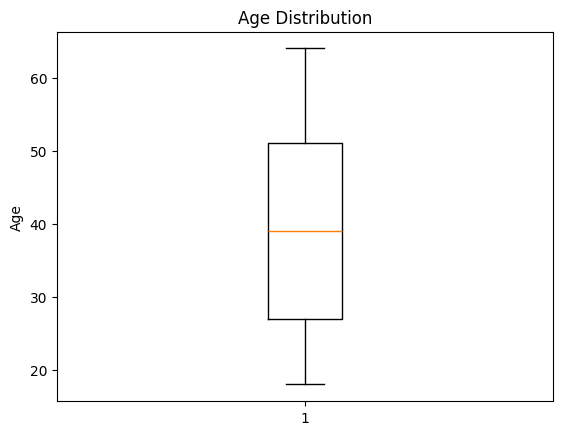

In [256]:
plt.boxplot(insurance_data_frame['age'])
plt.title('Age Distribution')
plt.ylabel('Age')
plt.show()

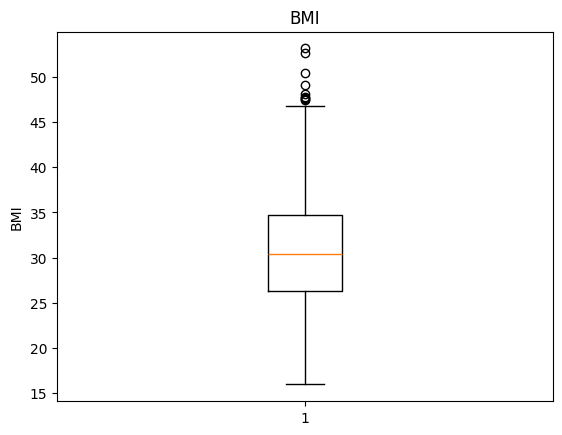

In [257]:
plt.boxplot(insurance_data_frame['bmi'])
plt.title('BMI')
plt.ylabel('BMI')
plt.show()

In [258]:
print(insurance_data_frame['bmi'].min())
print(insurance_data_frame['bmi'].max())

15.96
53.13


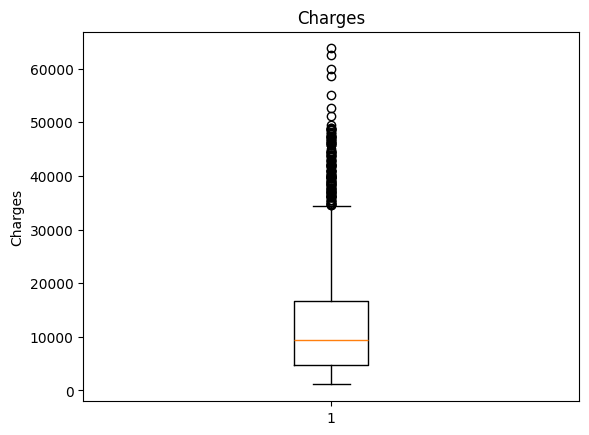

In [259]:
plt.boxplot(insurance_data_frame['charges'])
plt.title('Charges')
plt.ylabel('Charges')
plt.show()

In [260]:
print(insurance_data_frame['charges'].min())
print(insurance_data_frame['charges'].max())

1121.8739
63770.42801


### Analise de distribuição com o histograma

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'children'}>],
       [<Axes: title={'center': 'charges'}>,
        <Axes: title={'center': 'sex_female'}>,
        <Axes: title={'center': 'sex_male'}>],
       [<Axes: title={'center': 'smoker_no'}>,
        <Axes: title={'center': 'smoker_yes'}>,
        <Axes: title={'center': 'region_northeast'}>],
       [<Axes: title={'center': 'region_northwest'}>,
        <Axes: title={'center': 'region_southeast'}>,
        <Axes: title={'center': 'region_southwest'}>]], dtype=object)

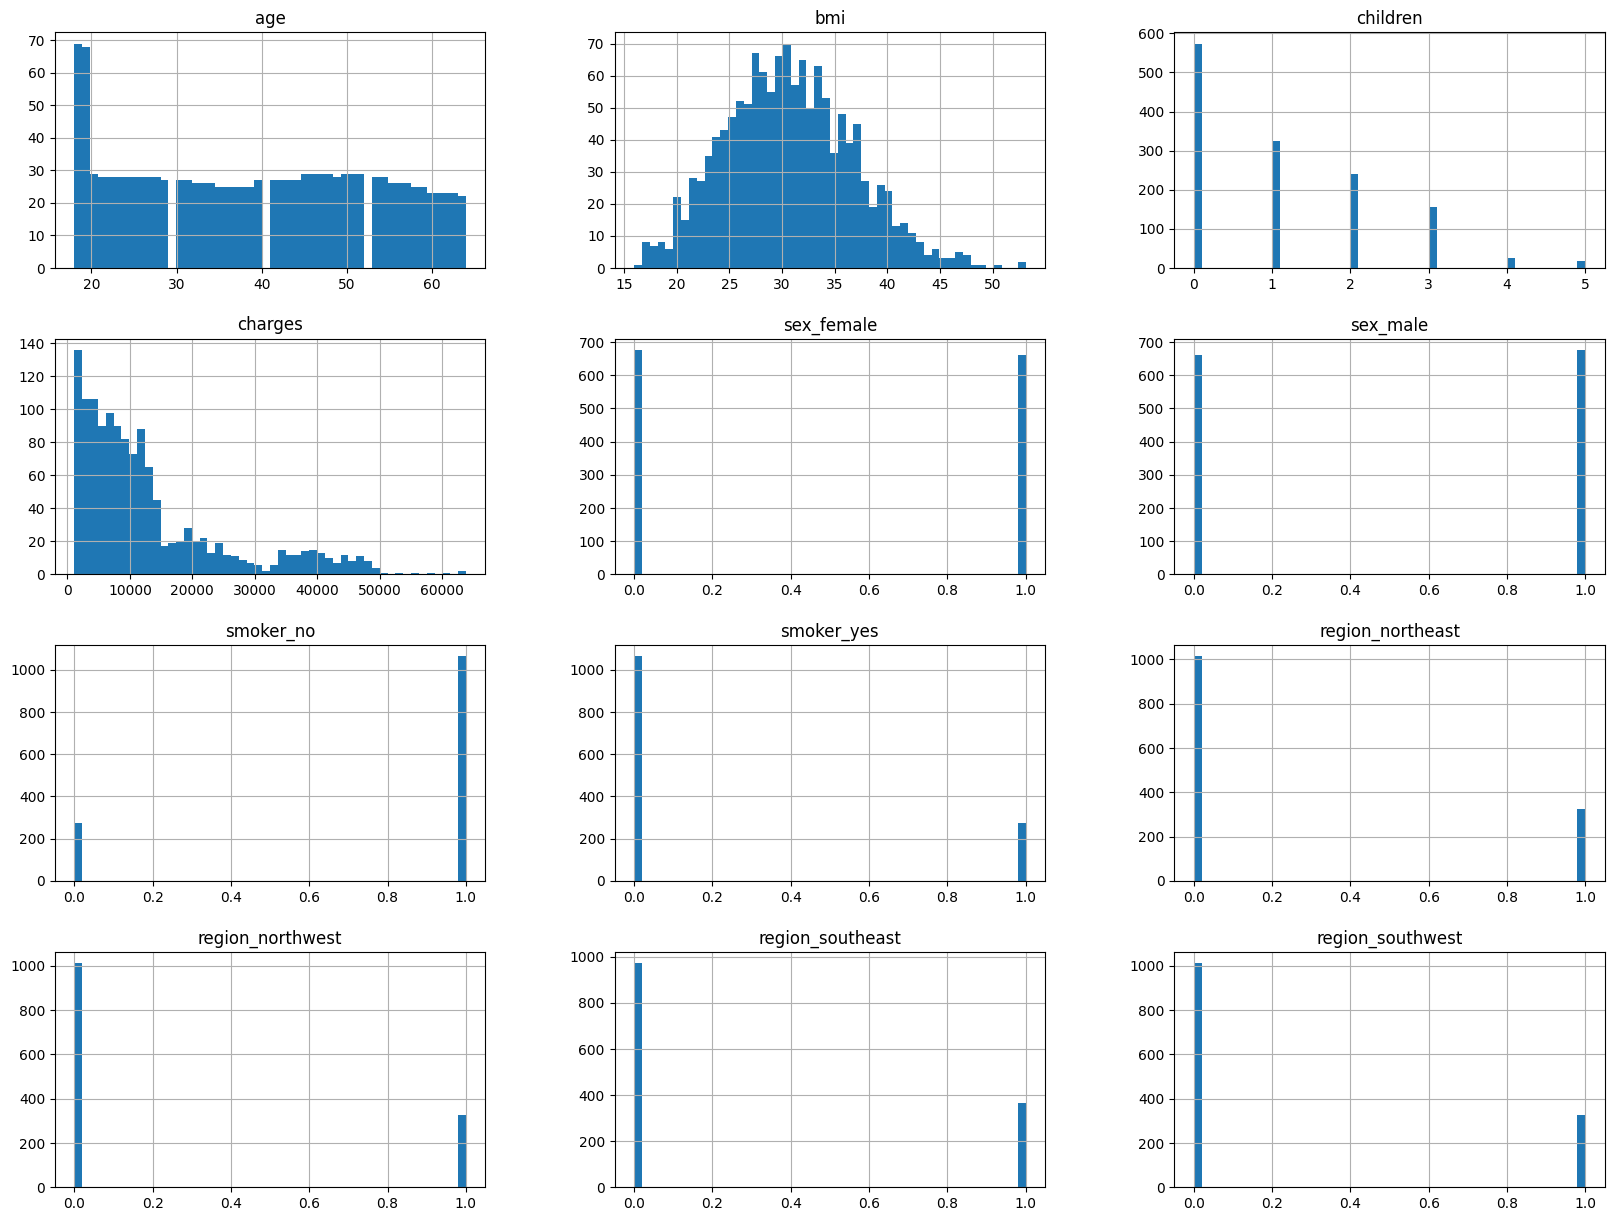

In [261]:
insurance_data_frame.hist(bins=50, figsize=(20, 15))

### Separação dos dados em treino e teste antes da normalização e padronização dos dados

In [262]:
x = insurance_data_frame.drop(columns=['charges'])
y = insurance_data_frame['charges']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Aplicando o MinMaxScaler

In [263]:
minMaxScaler = MinMaxScaler()

minMaxScaler.fit(x_train)

x_train_min_max_scaled = minMaxScaler.transform(x_train)
x_test_min_max_scaled= minMaxScaler.transform(x_test)

x_train_min_max_scaled

array([[0.60869565, 0.10734463, 0.4       , ..., 1.        , 0.        ,
        0.        ],
       [0.63043478, 0.22491256, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.73913043, 0.23944041, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.86956522, 0.24791499, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.41304348, 0.85122411, 0.4       , ..., 0.        , 0.        ,
        1.        ],
       [0.80434783, 0.37503363, 0.        , ..., 0.        , 0.        ,
        1.        ]], shape=(1070, 11))

### Aplicando o StandardScaler

In [264]:
standardScaler = StandardScaler()

standardScaler.fit(x_train)

x_train_standard_scaled = standardScaler.transform(x_train)
x_test_standard_scaled  = standardScaler.transform(x_test)

x_train_standard_scaled

array([[ 0.47222651, -1.75652513,  0.73433626, ...,  1.78316783,
        -0.59966106, -0.5723141 ],
       [ 0.54331294, -1.03308239, -0.91119211, ..., -0.56079971,
        -0.59966106, -0.5723141 ],
       [ 0.8987451 , -0.94368672, -0.91119211, ..., -0.56079971,
         1.66760869, -0.5723141 ],
       ...,
       [ 1.3252637 , -0.89153925, -0.91119211, ..., -0.56079971,
        -0.59966106, -0.5723141 ],
       [-0.16755139,  2.82086429,  0.73433626, ..., -0.56079971,
        -0.59966106,  1.74729228],
       [ 1.1120044 , -0.10932713, -0.91119211, ..., -0.56079971,
        -0.59966106,  1.74729228]], shape=(1070, 11))

### Aplicando o RobustScaler

In [265]:
robustScaler = RobustScaler()

robustScaler.fit(x_train)

x_train_robust_scaled = robustScaler.transform(x_train)
x_test_robust_scaled = robustScaler.transform(x_test)
x_train_robust_scaled

array([[ 0.27083333, -1.23744912,  0.5       , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.3125    , -0.71038746, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.52083333, -0.64525856, -0.5       , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.77083333, -0.6072667 , -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [-0.10416667,  2.09739183,  0.5       , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.64583333, -0.03738881, -0.5       , ...,  0.        ,
         0.        ,  1.        ]], shape=(1070, 11))

## Aplicação da Regresão Linear Multipla

In [266]:
def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape

In [267]:
def train_and_evaluate(scaler_name, x_train_scaled, x_test_scaled, y_train, y_test):
    print(f"Resultados para {scaler_name}:")
    
    # Criando o modelo de regressão linear
    linear_model = LinearRegression()
    linear_model.fit(x_train_scaled, y_train)
    
    # Previsões
    y_train_pred = linear_model.predict(x_train_scaled)
    y_test_pred = linear_model.predict(x_test_scaled)

    test_r2_score = r2_score(y_test, y_test_pred)
    train_r2_score = r2_score(y_train, y_train_pred)

    test_mean_squared_error = mean_squared_error(y_test, y_test_pred)
    train_mean_squared_error = mean_squared_error(y_train, y_train_pred)

    test_root_mean_squared_error = np.sqrt(test_mean_squared_error)
    train_root_mean_squared_error = np.sqrt(train_mean_squared_error)

    train_mape_result = calculate_mape(y_train, y_train_pred)
    test_mape_result = calculate_mape(y_test, y_test_pred)
    
    # Avaliação
    print("Treino:")
    print(f"  R²: {train_r2_score:.4f}")
    print(f"  MSE: {train_mean_squared_error:.4f}")
    print(f"  RMSE: {train_root_mean_squared_error:.4f}")
    print(f"  MAPE: {train_mape_result:.4f}%")
    
    print("Teste:")
    print(f"  R²: {test_r2_score:.4f}")
    print(f"  MSE: {test_mean_squared_error:.4f}")
    print(f"  RMSE: {test_root_mean_squared_error:.4f}")
    print(f"  MAPE: {test_mape_result:.4f}")
    

## Sem tratativa

In [268]:
train_and_evaluate("Sem tratativa", x_train, x_test, y_train, y_test)

Resultados para Sem tratativa:
Treino:
  R²: 0.7417
  MSE: 37277681.7020
  RMSE: 6105.5452
  MAPE: 42.2027%
Teste:
  R²: 0.7836
  MSE: 33596915.8514
  RMSE: 5796.2847
  MAPE: 46.8883


### Aplicando o MinMaxScaler

In [269]:
train_and_evaluate("MinMaxScaler", x_train_min_max_scaled, x_test_min_max_scaled, y_train, y_test)

Resultados para MinMaxScaler:
Treino:
  R²: 0.7417
  MSE: 37277681.7020
  RMSE: 6105.5452
  MAPE: 42.2027%
Teste:
  R²: 0.7836
  MSE: 33596915.8514
  RMSE: 5796.2847
  MAPE: 46.8883


### Aplicando StandardScaler

In [270]:
train_and_evaluate("StandardScaler", x_train_standard_scaled, x_test_standard_scaled, y_train, y_test)

Resultados para StandardScaler:
Treino:
  R²: 0.7417
  MSE: 37277681.7020
  RMSE: 6105.5452
  MAPE: 42.2027%
Teste:
  R²: 0.7836
  MSE: 33596915.8514
  RMSE: 5796.2847
  MAPE: 46.8883


### Aplicando RobustScaler

In [271]:
train_and_evaluate("RobustScaler", x_train_robust_scaled, x_test_robust_scaled, y_train, y_test)

Resultados para RobustScaler:
Treino:
  R²: 0.7417
  MSE: 37277681.7020
  RMSE: 6105.5452
  MAPE: 42.2027%
Teste:
  R²: 0.7836
  MSE: 33596915.8514
  RMSE: 5796.2847
  MAPE: 46.8883


Os resultados apresentados indicam que o modelo de regressão linear múltipla tem um desempenho consistente, independentemente do tipo de escalonamento aplicado. Vamos analisar as métricas:

1. R² (Coeficiente de Determinação)
Treino: 0.7417
Teste: 0.7836
Interpretação: O modelo explica cerca de 74% da variância dos dados no conjunto de treino e 78% no conjunto de teste. Esses valores são razoáveis, mas indicam que ainda há espaço para melhorias, pois cerca de 22-26% da variância não está sendo explicada.
2. MSE (Erro Quadrático Médio)
Treino: 37.28 milhões
Teste: 33.60 milhões
Interpretação: O MSE é alto devido à escala dos valores de charges. Isso é esperado, já que os custos médicos podem variar amplamente. O modelo está cometendo erros significativos em termos absolutos.
3. RMSE (Raiz do Erro Quadrático Médio)
Treino: 6105.55
Teste: 5796.28
Interpretação: O erro médio das previsões está em torno de 5800-6100 unidades monetárias. Isso pode ser aceitável dependendo do contexto do problema, mas ainda é um erro considerável.
4. MAPE (Erro Percentual Absoluto Médio)
Treino: 42.20%
Teste: 46.88%
Interpretação: O modelo apresenta um erro percentual médio alto, indicando que as previsões estão, em média, 42-47% distantes dos valores reais. Isso sugere que o modelo não está performando bem para prever valores de charges.


**Conclusão**

- Desempenho Geral: O modelo tem um desempenho moderado, mas o alto MAPE e RMSE indicam que ele não está capturando bem a relação entre as variáveis. Isso pode ser devido à natureza linear do modelo, que pode não ser suficiente para capturar relações mais complexas nos dados.

- Escalonamento: A ausência de variação nos resultados entre os diferentes escalonamentos confirma que a regressão linear não é sensível à escala dos dados.

**Próximos Passos:**
- Explorar Modelos Mais Complexos: Testar modelos não lineares, como árvores de decisão, random forest ou gradient boosting.
- Analisar Outliers: Verificar se outliers estão influenciando negativamente o modelo.
- Feature Engineering: Criar novas variáveis ou transformar as existentes para capturar melhor as relações nos dados.
- Avaliar Interações: Verificar se há interações entre variáveis que podem melhorar o desempenho do modelo.